In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# white background for matplotlib
matplotlib.rcParams['figure.facecolor'] = '#ffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform= ToTensor())

C:\Users\AnKy\AppData\Roaming\Python\Python39\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
image, label = dataset[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
5


In [4]:
# creating validation set
val_size = 10000
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
# creating dataloader
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2,num_workers=4,shuffle=True,pin_memory=True)

##Hidden Layers,Activation Functions and non-linearity

In [6]:
#reshaping
for images, labels in train_loader:
    print('images.shape: ',images.shape)
    inputs = images.reshape(-1,784)
    print('inputs.shape: ',inputs.shape)
    break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shape:  torch.Size([128, 784])


In [7]:
# creating hidden layer
input_size = inputs.shape[-1]
hidden_size = 32  #this is output size we can control it in hidden layer

In [8]:
layer1 = nn.Linear(input_size, hidden_size)

In [9]:
inputs.shape

torch.Size([128, 784])

In [10]:
layer1_outputs = layer1(inputs)
print(layer1_outputs.shape)

torch.Size([128, 32])


We will use relu function here it changes all negative values of matrix to zero

In [11]:
relu_outputs = F.relu(layer1_outputs)
print('min((layer1_outputs)): ', torch.min(layer1_outputs).item())

print('min((relu_outputs)): ', torch.min(relu_outputs).item())

min((layer1_outputs)):  -0.7301419973373413
min((relu_outputs)):  0.0


we have 10 outputs so we will set output size in hidden layer

In [12]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)


In [13]:
relu_outputs.shape

torch.Size([128, 32])

In [14]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [18]:
# define model
class MnistModel(nn.Module):
    def __init__(self,in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self,xb):
        #flatting image tensor
        xb = xb.view(xb.size(0), -1)
        #hidden layers outputs
        out = self.linear1(xb)
        # applying relu
        out = F.relu(out)
        #predicting using output layer
        out = self.linear2(out)

        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

    


In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim =1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
input_size = 784
hidden_size = 32
num_classes = 10

In [21]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [22]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [24]:
for images, labels in train_loader:
    outputs = model(images)
    break
loss = F.cross_entropy(outputs, labels)
print('Loss: ',loss.item())
print('outputs.shape: ',outputs.shape)
print('sample outputs: \n', outputs[:2].data)

Loss:  2.322275161743164
outputs.shape:  torch.Size([128, 10])
sample outputs: 
 tensor([[ 0.0204,  0.0554,  0.0515, -0.1801, -0.1064,  0.1073,  0.2186, -0.1572,
          0.0581,  0.0196],
        [-0.0304,  0.0107,  0.0095, -0.1721, -0.0504,  0.0988,  0.2342, -0.2487,
          0.1504,  0.1246]])


Using a GPU

In [26]:
def  get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
#moving data between gpu and cpu
def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return[to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [31]:
for images, labels in train_loader:
    print(images.shape)
    print('device-before: ',images.device)
    images = to_device(images, device)
    print('device-after: ',images.device)
    break

torch.Size([128, 1, 28, 28])
device-before:  cpu
device-after:  cuda:0


In [32]:
class DeviceDataLoader():
    """ wrap dataloader to move data to device"""
    def __init__(self, dl , device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """ number of batches"""
        return len(self.dl)

In [33]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [36]:
#training model

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [42]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.298090934753418, 'val_acc': 0.12880858778953552}]

In [43]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch[0], val_loss: 0.2508, val_acc: 0.9244
Epoch[1], val_loss: 0.1799, val_acc: 0.9438
Epoch[2], val_loss: 0.1536, val_acc: 0.9524
Epoch[3], val_loss: 0.1399, val_acc: 0.9544
Epoch[4], val_loss: 0.1270, val_acc: 0.9602


Text(0.5, 1.0, 'Loss VS No.of Epochs')

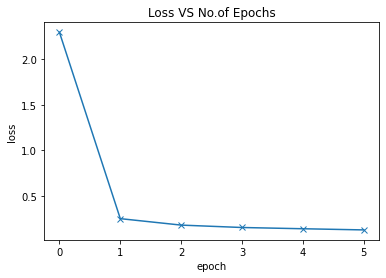

In [44]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss VS No.of Epochs')



In [45]:
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())


In [46]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    print(xb.device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)

    return preds[0].item()


cuda:0
Label:  7 ,Predicted:  7


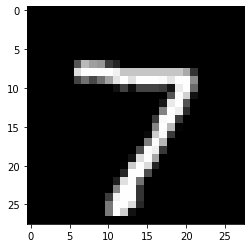

In [47]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,',Predicted: ', predict_image(img,model))

cuda:0
Label:  2 ,Predicted:  2


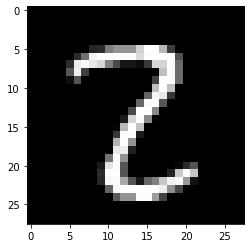

In [48]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,',Predicted: ', predict_image(img,model))

cuda:0
Label:  9 ,Predicted:  9


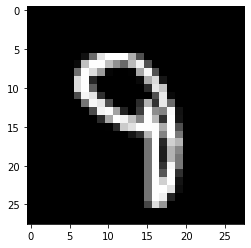

In [49]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,',Predicted: ', predict_image(img,model))

cuda:0
Label:  3 ,Predicted:  3


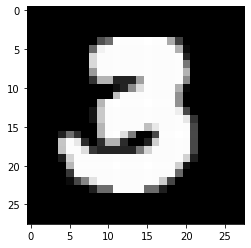

In [50]:
img, label = test_dataset[200]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,',Predicted: ', predict_image(img,model))

cuda:0
Label:  1 ,Predicted:  1


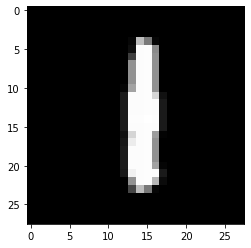

In [51]:
img, label = test_dataset[267]
plt.imshow(img[0], cmap='gray')
print('Label: ',label,',Predicted: ', predict_image(img,model))